In [3]:
!pip install transformers==4.37.2 accelerate==0.27.2 datasets evaluate peft==0.10.0 --quiet


In [4]:
!pip install streamlit

In [5]:
import pandas as pd
import spacy
import kagglehub
from collections import defaultdict
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import joblib

d:\anaconda\envs\airfrance_nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from transformers import Trainer, TrainingArguments
print("Trainer and Transformers are working!")


W0624 10:18:15.667000 1968 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Trainer and Transformers are working!


In [7]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to

True

In [8]:
path = kagglehub.dataset_download("yasserh/twitter-tweets-sentiment-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\yasserh\twitter-tweets-sentiment-dataset\versions\1


In [9]:
df = pd.read_csv(path + "/Tweets.csv")
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


## Data Preprocessing

In [11]:
# drop selected_text & text ID column
#df.drop(['selected_text', 'textID'], axis=1, inplace=True)

In [12]:
df.isnull().values.any()

True

In [13]:
df = df.dropna()

In [14]:
# check duplicated rows
df.duplicated().sum()

0

In [15]:
df = df.reset_index(drop = True)
df.head(50)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


### Text Normalization

In [16]:
# Define selected_text normalization function
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-z0-9\s]', '', text)  # remove special characters except letters, numbers, and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    return text

# Apply normalization to the tweet selected text column
df['normalized_text'] = df['selected_text'].apply(normalize_text)

# Check the result
print(df['normalized_text'].head(20))

0                     id have responded if i were going
1                                              sooo sad
2                                           bullying me
3                                        leave me alone
4                                               sons of
5     some shameless plugging for the best rangers f...
6                                                   fun
7                                            soooo high
8                                           both of you
9                              wow u just became cooler
10    as much as i love to be hopeful i reckon the c...
11                                                 like
12                                          dangerously
13                                                 lost
14                           test test from the lg env2
15                                 uh oh i am sunburned
16                                                 sigh
17                                              

### Tokenization

In [17]:
def tokenize_text(normalize_text):
    if not isinstance(normalize_text, str):
        return []
    return normalize_text.split()

df['tokenized_text'] = df['normalized_text'].apply(tokenize_text)

# Check the result
print(df['tokenized_text'].head(20))


0             [id, have, responded, if, i, were, going]
1                                           [sooo, sad]
2                                        [bullying, me]
3                                    [leave, me, alone]
4                                            [sons, of]
5     [some, shameless, plugging, for, the, best, ra...
6                                                 [fun]
7                                         [soooo, high]
8                                       [both, of, you]
9                        [wow, u, just, became, cooler]
10    [as, much, as, i, love, to, be, hopeful, i, re...
11                                               [like]
12                                        [dangerously]
13                                               [lost]
14                    [test, test, from, the, lg, env2]
15                           [uh, oh, i, am, sunburned]
16                                               [sigh]
17                                              

### Stopword Removal

In [18]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokenized_text):
    if not isinstance(tokenized_text, list):
        return []
    filtered_tokens = [word for word in tokenized_text if word not in stop_words]
    return filtered_tokens

df['stopword_text'] = df['tokenized_text'].apply(remove_stopwords)

# Check the result
print(df['stopword_text'].head(20))


0                                [id, responded, going]
1                                           [sooo, sad]
2                                            [bullying]
3                                        [leave, alone]
4                                                [sons]
5     [shameless, plugging, best, rangers, forum, ea...
6                                                 [fun]
7                                         [soooo, high]
8                                                    []
9                              [wow, u, became, cooler]
10    [much, love, hopeful, reckon, chances, minimal...
11                                               [like]
12                                        [dangerously]
13                                               [lost]
14                               [test, test, lg, env2]
15                                  [uh, oh, sunburned]
16                                               [sigh]
17                                              

### Lemmetization

In [19]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def lemmatize_tokens_with_pos(tokens):
    if not isinstance(tokens, list):
        return []
    pos_tagged = nltk.pos_tag(tokens)  # POS tagging
    lemmatized = [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tagged]
    return lemmatized

df['lemmetized_text'] = df['stopword_text'].apply(lemmatize_tokens_with_pos)

print(df['lemmetized_text'].head(20))

0                                     [id, respond, go]
1                                           [sooo, sad]
2                                            [bullying]
3                                        [leave, alone]
4                                                 [son]
5         [shameless, plug, best, ranger, forum, earth]
6                                                 [fun]
7                                         [soooo, high]
8                                                    []
9                              [wow, u, become, cooler]
10    [much, love, hopeful, reckon, chance, minimal,...
11                                               [like]
12                                        [dangerously]
13                                               [lose]
14                               [test, test, lg, env2]
15                                    [uh, oh, sunburn]
16                                               [sigh]
17                                              

### Remove Empty Rows After Preprocessed

In [20]:
df = df[df['lemmetized_text'].apply(lambda x: isinstance(x, list) and len(x) > 0)].reset_index(drop=True)

In [21]:
df.head(20)

,textID,text,selected_text,sentiment,normalized_text,tokenized_text,stopword_text,lemmetized_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going,"[id, have, responded, if, i, were, going]","[id, responded, going]","[id, respond, go]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad,"[sooo, sad]","[sooo, sad]","[sooo, sad]"
2,088c60f138,my boss is bullying me...,bullying me,negative,bullying me,"[bullying, me]",[bullying],[bullying]
3,9642c003ef,what interview! leave me alone,leave me alone,negative,leave me alone,"[leave, me, alone]","[leave, alone]","[leave, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of,"[sons, of]",[sons],[son]
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,some shameless plugging for the best rangers f...,"[some, shameless, plugging, for, the, best, ra...","[shameless, plugging, best, rangers, forum, ea...","[shameless, plug, best, ranger, forum, earth]"
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,fun,[fun],[fun],[fun]
7,50e14c0bb8,Soooo high,Soooo high,neutral,soooo high,"[soooo, high]","[soooo, high]","[soooo, high]"
8,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,wow u just became cooler,"[wow, u, just, became, cooler]","[wow, u, became, cooler]","[wow, u, become, cooler]"
9,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,as much as i love to be hopeful i reckon the c...,"[as, much, as, i, love, to, be, hopeful, i, re...","[much, love, hopeful, reckon, chances, minimal...","[much, love, hopeful, reckon, chance, minimal,..."


## Feature Engineering

### TF-IDF

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

df['tfidf_text'] = df['lemmetized_text'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else '')

# apply TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=3000)  # You can adjust max_features as needed
tfidf_matrix = vectorizer.fit_transform(df['tfidf_text'])

print(tfidf_matrix.shape)  # (num_samples, num_features)

joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


(27265, 3000)


['tfidf_vectorizer.pkl']

### BERT Embeddings

In [23]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from tqdm import tqdm
import numpy as np

# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')


def get_distilbert_embedding(text):
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Get embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the [CLS]-like representation (first token)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

texts = df['selected_text'].fillna('').tolist()[:3000]
distilbert_embeddings = []

for text in tqdm(texts): 
    vec = get_distilbert_embedding(text)
    distilbert_embeddings.append(vec)

# Convert to array
X_distil = np.array(distilbert_embeddings)


d:\anaconda\envs\airfrance_nlp\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 3000/3000 [00:54<00:00, 54.90it/s]


# Model Development and Evaluation

## Traditional ML Model

### Setup For All Models

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Map sentiment to label
df['label'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# Sample 3000 rows with class balance (1000 per class if 3 classes)
n_per_class = 1000
sampled_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=n_per_class, random_state=42))

# Slice TF-IDF matrix to match sample
X_sample = tfidf_matrix[sampled_df.index]
y_sample = sampled_df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42
)

print(f"Dataset ready: {len(y_train)} train, {len(y_test)} test")
joblib.dump(y_test, "y_test.pkl")

Dataset ready: 2400 train, 600 test


C:\Users\user\AppData\Local\Temp\ipykernel_1968\1188361331.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=n_per_class, random_state=42))


['y_test.pkl']

### Logistic Regression with Hyperparameter Tuning (GridSearchCV)

In [25]:
from tabulate import tabulate

In [26]:
# Hyperparameter grid
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [500, 1000]
}

# Grid search
grid_logreg = GridSearchCV(LogisticRegression(multi_class='multinomial'), param_grid_logreg, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_logreg.fit(X_train, y_train)

# Results
best_logreg = grid_logreg.best_estimator_
print(f"Best Logistic Regression params: {grid_logreg.best_params_}")
y_pred_log = best_logreg.predict(X_test)
print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_log, target_names=['Negative', 'Neutral', 'Positive']))

# Combine into DataFrame: Actual vs Predicted
# Get the original tweet text for the test set
test_tweets = sampled_df.loc[y_test.index, 'text'].values

results_df = pd.DataFrame({
    'Tweet': test_tweets,
    'Actual Sentiment': y_test.values,
    'Predicted Sentiment': y_pred_log,
})

print(tabulate(results_df.head(20), headers='keys', tablefmt='psql'))

joblib.dump(best_logreg, "logreg_model.pkl")
joblib.dump(y_pred_log, "y_pred_log.pkl")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Logistic Regression params: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Logistic Regression Classification Report
              precision    recall  f1-score   support

    Negative       0.70      0.72      0.71       200
     Neutral       0.68      0.70      0.69       200
    Positive       0.81      0.76      0.78       200

    accuracy                           0.73       600
   macro avg       0.73      0.73      0.73       600
weighted avg       0.73      0.73      0.73       600

+----+----------------------------------------------------------------------------------------------------------------+--------------------+-----------------------+
|    | Tweet                                                                                                          |   Actual Sentiment |   Predicted Sentiment |
|----+-------------------------------------------------------------------------------------

d:\anaconda\envs\airfrance_nlp\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


['y_pred_log.pkl']

### Support Vector Machine (SVM) with Hyperparameter tuning GridSearchCV

In [27]:
# Hyperparameter grid
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Grid search
svm_grid = GridSearchCV(SVC(probability=True), svm_params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
svm_grid.fit(X_train, y_train)

# Results
svm_best = svm_grid.best_estimator_
print(f"Best SVM parameters: {svm_grid.best_params_}")
y_pred_svm = svm_best.predict(X_test)
print("SVM Classification Report")
print(classification_report(y_test, y_pred_svm, target_names=['Negative', 'Neutral', 'Positive']))

# Combine into DataFrame: Actual vs Predicted
# Get the original tweet text for the test set
test_tweets = sampled_df.loc[y_test.index, 'text'].values

results_df = pd.DataFrame({
    'Tweet': test_tweets,
    'Actual Sentiment': y_test.values,
    'Predicted Sentiment': y_pred_svm
})

print(tabulate(results_df.head(20), headers='keys', tablefmt='psql'))

joblib.dump(svm_best, "svm_model.pkl")
joblib.dump(y_pred_svm, "y_pred_svm.pkl")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
SVM Classification Report
              precision    recall  f1-score   support

    Negative       0.72      0.73      0.72       200
     Neutral       0.69      0.70      0.70       200
    Positive       0.81      0.78      0.79       200

    accuracy                           0.74       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.74      0.74      0.74       600

+----+----------------------------------------------------------------------------------------------------------------+--------------------+-----------------------+
|    | Tweet                                                                                                          |   Actual Sentiment |   Predicted Sentiment |
|----+----------------------------------------------------------------------------------------------------------------+---------------

['y_pred_svm.pkl']

### Random Forest Classifier with Hyperparameter Tuning GridSearchCV

In [28]:
# Hyperparameter grid
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid search
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

# Results
rf_best = rf_grid.best_estimator_
print(f"Best Random Forest parameters: {rf_grid.best_params_}")
y_pred_rf = rf_best.predict(X_test)
print("Random Forest Classification Report")
print(classification_report(y_test, y_pred_rf, target_names=['Negative', 'Neutral', 'Positive']))

results_df = pd.DataFrame({
    'Tweet': test_tweets,
    'Actual Sentiment': y_test.values,
    'Predicted Sentiment': y_pred_rf
})

print(tabulate(results_df.head(20), headers='keys', tablefmt='psql'))

joblib.dump(rf_best, "rf_model.pkl")
joblib.dump(y_pred_rf, "y_pred_rf.pkl")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Classification Report
              precision    recall  f1-score   support

    Negative       0.69      0.79      0.74       200
     Neutral       0.73      0.70      0.72       200
    Positive       0.83      0.75      0.79       200

    accuracy                           0.75       600
   macro avg       0.75      0.75      0.75       600
weighted avg       0.75      0.75      0.75       600

+----+----------------------------------------------------------------------------------------------------------------+--------------------+-----------------------+
|    | Tweet                                                                                                          |   Actual Sentiment |   Predicted Sentiment |
|----+-------------------------------------------------------------------

['y_pred_rf.pkl']

## Transformers Model

### Transformer -> Fine-Tune DistilBERT for Sentiment Classification with hyperparameter tuning

In [29]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from transformers import DistilBertTokenizer

# Limit to first 3000 rows with non-null text and valid sentiment
df_limited = df[['selected_text', 'sentiment']].dropna().copy()
df_limited = df_limited[df_limited['sentiment'].isin(['positive', 'neutral', 'negative'])].iloc[:3000]

# Map sentiment to labels
df_limited['label'] = df_limited['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_limited['selected_text'].tolist(),
    df_limited['label'].tolist(),
    test_size=0.2,
    stratify=df_limited['label'],
    random_state=42
)

# Tokenize
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Dataset class
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}
    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

print(f"Dataset ready: {len(train_dataset)} train, {len(test_dataset)} test")


d:\anaconda\envs\airfrance_nlp\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Dataset ready: 2400 train, 600 test


In [30]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    save_strategy="no",
    report_to="none",
    disable_tqdm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/450 [00:00<?, ?it/s]d:\anaconda\envs\airfrance_nlp\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  1%|          | 5/450 [00:08<12:50,  1.73s/it]

{'loss': 1.0568, 'learning_rate': 4.9444444444444446e-05, 'epoch': 0.03}


  2%|▏         | 10/450 [00:16<12:19,  1.68s/it]

{'loss': 0.9848, 'learning_rate': 4.888888888888889e-05, 'epoch': 0.07}


  3%|▎         | 15/450 [00:25<12:29,  1.72s/it]

{'loss': 1.0019, 'learning_rate': 4.8333333333333334e-05, 'epoch': 0.1}


  4%|▍         | 20/450 [00:34<12:32,  1.75s/it]

{'loss': 1.0535, 'learning_rate': 4.7777777777777784e-05, 'epoch': 0.13}


  6%|▌         | 25/450 [00:43<12:11,  1.72s/it]

{'loss': 1.0262, 'learning_rate': 4.722222222222222e-05, 'epoch': 0.17}


  7%|▋         | 30/450 [00:51<12:01,  1.72s/it]

{'loss': 0.8412, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.2}


  8%|▊         | 35/450 [01:00<11:53,  1.72s/it]

{'loss': 0.8459, 'learning_rate': 4.6111111111111115e-05, 'epoch': 0.23}


  9%|▉         | 40/450 [01:08<11:41,  1.71s/it]

{'loss': 1.0106, 'learning_rate': 4.555555555555556e-05, 'epoch': 0.27}


 10%|█         | 45/450 [01:17<11:25,  1.69s/it]

{'loss': 0.8461, 'learning_rate': 4.5e-05, 'epoch': 0.3}


 11%|█         | 50/450 [01:25<11:30,  1.73s/it]

{'loss': 0.827, 'learning_rate': 4.4444444444444447e-05, 'epoch': 0.33}


 12%|█▏        | 55/450 [01:34<10:55,  1.66s/it]

{'loss': 0.8788, 'learning_rate': 4.388888888888889e-05, 'epoch': 0.37}


 13%|█▎        | 60/450 [01:42<10:34,  1.63s/it]

{'loss': 0.6824, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.4}


 14%|█▍        | 65/450 [01:50<10:51,  1.69s/it]

{'loss': 0.5729, 'learning_rate': 4.277777777777778e-05, 'epoch': 0.43}


 16%|█▌        | 70/450 [01:59<10:39,  1.68s/it]

{'loss': 0.4854, 'learning_rate': 4.222222222222222e-05, 'epoch': 0.47}


 17%|█▋        | 75/450 [02:07<10:23,  1.66s/it]

{'loss': 0.5595, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.5}


 18%|█▊        | 80/450 [02:15<10:29,  1.70s/it]

{'loss': 0.3277, 'learning_rate': 4.111111111111111e-05, 'epoch': 0.53}


 19%|█▉        | 85/450 [02:24<10:51,  1.79s/it]

{'loss': 0.6101, 'learning_rate': 4.055555555555556e-05, 'epoch': 0.57}


 20%|██        | 90/450 [02:33<10:13,  1.70s/it]

{'loss': 0.5949, 'learning_rate': 4e-05, 'epoch': 0.6}


 21%|██        | 95/450 [02:41<09:53,  1.67s/it]

{'loss': 0.4112, 'learning_rate': 3.944444444444445e-05, 'epoch': 0.63}


 22%|██▏       | 100/450 [02:50<09:51,  1.69s/it]

{'loss': 0.4624, 'learning_rate': 3.888888888888889e-05, 'epoch': 0.67}


 23%|██▎       | 105/450 [02:58<09:40,  1.68s/it]

{'loss': 0.4218, 'learning_rate': 3.8333333333333334e-05, 'epoch': 0.7}


 24%|██▍       | 110/450 [03:06<09:36,  1.70s/it]

{'loss': 0.3558, 'learning_rate': 3.777777777777778e-05, 'epoch': 0.73}


 26%|██▌       | 115/450 [03:15<09:26,  1.69s/it]

{'loss': 0.4763, 'learning_rate': 3.722222222222222e-05, 'epoch': 0.77}


 27%|██▋       | 120/450 [03:24<09:26,  1.72s/it]

{'loss': 0.4192, 'learning_rate': 3.6666666666666666e-05, 'epoch': 0.8}


 28%|██▊       | 125/450 [03:32<09:15,  1.71s/it]

{'loss': 0.4227, 'learning_rate': 3.611111111111111e-05, 'epoch': 0.83}


 29%|██▉       | 130/450 [03:41<09:06,  1.71s/it]

{'loss': 0.5569, 'learning_rate': 3.555555555555556e-05, 'epoch': 0.87}


 30%|███       | 135/450 [03:49<09:11,  1.75s/it]

{'loss': 0.2871, 'learning_rate': 3.5e-05, 'epoch': 0.9}


 31%|███       | 140/450 [03:58<08:50,  1.71s/it]

{'loss': 0.4581, 'learning_rate': 3.444444444444445e-05, 'epoch': 0.93}


 32%|███▏      | 145/450 [04:06<08:39,  1.70s/it]

{'loss': 0.4617, 'learning_rate': 3.388888888888889e-05, 'epoch': 0.97}


 33%|███▎      | 150/450 [04:15<08:29,  1.70s/it]

{'loss': 0.3287, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


                                                 
 33%|███▎      | 150/450 [04:29<08:29,  1.70s/it]

{'eval_loss': 0.38224759697914124, 'eval_runtime': 13.99, 'eval_samples_per_second': 42.888, 'eval_steps_per_second': 0.715, 'epoch': 1.0}


 34%|███▍      | 155/450 [04:37<13:17,  2.70s/it]

{'loss': 0.3195, 'learning_rate': 3.277777777777778e-05, 'epoch': 1.03}


 36%|███▌      | 160/450 [04:46<08:53,  1.84s/it]

{'loss': 0.3705, 'learning_rate': 3.222222222222223e-05, 'epoch': 1.07}


 37%|███▋      | 165/450 [04:54<08:18,  1.75s/it]

{'loss': 0.3938, 'learning_rate': 3.1666666666666666e-05, 'epoch': 1.1}


 38%|███▊      | 170/450 [05:03<07:53,  1.69s/it]

{'loss': 0.1821, 'learning_rate': 3.111111111111111e-05, 'epoch': 1.13}


 39%|███▉      | 175/450 [05:12<08:44,  1.91s/it]

{'loss': 0.3682, 'learning_rate': 3.055555555555556e-05, 'epoch': 1.17}


 40%|████      | 180/450 [05:22<08:46,  1.95s/it]

{'loss': 0.2318, 'learning_rate': 3e-05, 'epoch': 1.2}


 41%|████      | 185/450 [05:33<09:14,  2.09s/it]

{'loss': 0.2111, 'learning_rate': 2.9444444444444448e-05, 'epoch': 1.23}


 42%|████▏     | 190/450 [05:42<08:24,  1.94s/it]

{'loss': 0.4009, 'learning_rate': 2.8888888888888888e-05, 'epoch': 1.27}


 43%|████▎     | 195/450 [05:54<10:09,  2.39s/it]

{'loss': 0.3137, 'learning_rate': 2.8333333333333335e-05, 'epoch': 1.3}


 44%|████▍     | 200/450 [06:05<09:18,  2.23s/it]

{'loss': 0.4316, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.33}


 46%|████▌     | 205/450 [06:19<10:52,  2.66s/it]

{'loss': 0.2303, 'learning_rate': 2.7222222222222223e-05, 'epoch': 1.37}


 47%|████▋     | 210/450 [06:30<09:06,  2.28s/it]

{'loss': 0.4562, 'learning_rate': 2.6666666666666667e-05, 'epoch': 1.4}


 48%|████▊     | 215/450 [06:41<08:43,  2.23s/it]

{'loss': 0.4198, 'learning_rate': 2.6111111111111114e-05, 'epoch': 1.43}


 49%|████▉     | 220/450 [06:54<09:52,  2.58s/it]

{'loss': 0.2405, 'learning_rate': 2.5555555555555554e-05, 'epoch': 1.47}


 50%|█████     | 225/450 [07:05<08:18,  2.21s/it]

{'loss': 0.338, 'learning_rate': 2.5e-05, 'epoch': 1.5}


 51%|█████     | 230/450 [07:15<07:46,  2.12s/it]

{'loss': 0.2731, 'learning_rate': 2.4444444444444445e-05, 'epoch': 1.53}


 52%|█████▏    | 235/450 [07:26<07:41,  2.15s/it]

{'loss': 0.3127, 'learning_rate': 2.3888888888888892e-05, 'epoch': 1.57}


 53%|█████▎    | 240/450 [07:37<07:24,  2.12s/it]

{'loss': 0.2509, 'learning_rate': 2.3333333333333336e-05, 'epoch': 1.6}


 54%|█████▍    | 245/450 [07:48<07:10,  2.10s/it]

{'loss': 0.2627, 'learning_rate': 2.277777777777778e-05, 'epoch': 1.63}


 56%|█████▌    | 250/450 [07:58<07:06,  2.13s/it]

{'loss': 0.2588, 'learning_rate': 2.2222222222222223e-05, 'epoch': 1.67}


 57%|█████▋    | 255/450 [08:09<06:46,  2.09s/it]

{'loss': 0.2272, 'learning_rate': 2.1666666666666667e-05, 'epoch': 1.7}


 58%|█████▊    | 260/450 [08:19<06:31,  2.06s/it]

{'loss': 0.3322, 'learning_rate': 2.111111111111111e-05, 'epoch': 1.73}


 59%|█████▉    | 265/450 [08:30<06:31,  2.12s/it]

{'loss': 0.4529, 'learning_rate': 2.0555555555555555e-05, 'epoch': 1.77}


 60%|██████    | 270/450 [08:40<06:13,  2.08s/it]

{'loss': 0.3677, 'learning_rate': 2e-05, 'epoch': 1.8}


 61%|██████    | 275/450 [08:51<06:06,  2.09s/it]

{'loss': 0.1734, 'learning_rate': 1.9444444444444445e-05, 'epoch': 1.83}


 62%|██████▏   | 280/450 [09:00<05:39,  2.00s/it]

{'loss': 0.2763, 'learning_rate': 1.888888888888889e-05, 'epoch': 1.87}


 63%|██████▎   | 285/450 [09:11<05:33,  2.02s/it]

{'loss': 0.2627, 'learning_rate': 1.8333333333333333e-05, 'epoch': 1.9}


 64%|██████▍   | 290/450 [09:21<05:25,  2.03s/it]

{'loss': 0.3255, 'learning_rate': 1.777777777777778e-05, 'epoch': 1.93}


 66%|██████▌   | 295/450 [09:31<05:19,  2.06s/it]

{'loss': 0.4128, 'learning_rate': 1.7222222222222224e-05, 'epoch': 1.97}


 67%|██████▋   | 300/450 [09:41<05:06,  2.04s/it]

{'loss': 0.3287, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


                                                 
 67%|██████▋   | 300/450 [09:58<05:06,  2.04s/it]

{'eval_loss': 0.35894545912742615, 'eval_runtime': 16.5341, 'eval_samples_per_second': 36.289, 'eval_steps_per_second': 0.605, 'epoch': 2.0}


 68%|██████▊   | 305/450 [10:08<07:48,  3.23s/it]

{'loss': 0.2906, 'learning_rate': 1.6111111111111115e-05, 'epoch': 2.03}


 69%|██████▉   | 310/450 [10:18<05:05,  2.18s/it]

{'loss': 0.2248, 'learning_rate': 1.5555555555555555e-05, 'epoch': 2.07}


 70%|███████   | 315/450 [10:28<04:31,  2.01s/it]

{'loss': 0.0924, 'learning_rate': 1.5e-05, 'epoch': 2.1}


 71%|███████   | 320/450 [10:37<03:53,  1.79s/it]

{'loss': 0.2643, 'learning_rate': 1.4444444444444444e-05, 'epoch': 2.13}


 72%|███████▏  | 325/450 [10:46<03:36,  1.73s/it]

{'loss': 0.2404, 'learning_rate': 1.388888888888889e-05, 'epoch': 2.17}


 73%|███████▎  | 330/450 [10:54<03:26,  1.72s/it]

{'loss': 0.17, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.2}


 74%|███████▍  | 335/450 [11:04<03:30,  1.83s/it]

{'loss': 0.1731, 'learning_rate': 1.2777777777777777e-05, 'epoch': 2.23}


 76%|███████▌  | 340/450 [11:12<03:13,  1.76s/it]

{'loss': 0.2786, 'learning_rate': 1.2222222222222222e-05, 'epoch': 2.27}


 77%|███████▋  | 345/450 [11:21<03:02,  1.74s/it]

{'loss': 0.121, 'learning_rate': 1.1666666666666668e-05, 'epoch': 2.3}


 78%|███████▊  | 350/450 [11:30<03:05,  1.85s/it]

{'loss': 0.1507, 'learning_rate': 1.1111111111111112e-05, 'epoch': 2.33}


 79%|███████▉  | 355/450 [11:41<03:09,  2.00s/it]

{'loss': 0.1103, 'learning_rate': 1.0555555555555555e-05, 'epoch': 2.37}


 80%|████████  | 360/450 [11:50<02:56,  1.96s/it]

{'loss': 0.1333, 'learning_rate': 1e-05, 'epoch': 2.4}


 81%|████████  | 365/450 [11:59<02:28,  1.75s/it]

{'loss': 0.1929, 'learning_rate': 9.444444444444445e-06, 'epoch': 2.43}


 82%|████████▏ | 370/450 [12:08<02:17,  1.72s/it]

{'loss': 0.2352, 'learning_rate': 8.88888888888889e-06, 'epoch': 2.47}


 83%|████████▎ | 375/450 [12:16<02:08,  1.71s/it]

{'loss': 0.1512, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.5}


 84%|████████▍ | 380/450 [12:27<02:18,  1.98s/it]

{'loss': 0.175, 'learning_rate': 7.777777777777777e-06, 'epoch': 2.53}


 86%|████████▌ | 385/450 [12:37<02:11,  2.03s/it]

{'loss': 0.1472, 'learning_rate': 7.222222222222222e-06, 'epoch': 2.57}


 87%|████████▋ | 390/450 [12:47<02:00,  2.00s/it]

{'loss': 0.1118, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.6}


 88%|████████▊ | 395/450 [12:57<01:52,  2.04s/it]

{'loss': 0.1952, 'learning_rate': 6.111111111111111e-06, 'epoch': 2.63}


 89%|████████▉ | 400/450 [13:07<01:40,  2.01s/it]

{'loss': 0.1108, 'learning_rate': 5.555555555555556e-06, 'epoch': 2.67}


 90%|█████████ | 405/450 [13:18<01:30,  2.02s/it]

{'loss': 0.0555, 'learning_rate': 5e-06, 'epoch': 2.7}


 91%|█████████ | 410/450 [13:28<01:20,  2.01s/it]

{'loss': 0.175, 'learning_rate': 4.444444444444445e-06, 'epoch': 2.73}


 92%|█████████▏| 415/450 [13:38<01:10,  2.02s/it]

{'loss': 0.1931, 'learning_rate': 3.888888888888889e-06, 'epoch': 2.77}


 93%|█████████▎| 420/450 [13:48<00:59,  1.99s/it]

{'loss': 0.2996, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.8}


 94%|█████████▍| 425/450 [13:58<00:49,  1.98s/it]

{'loss': 0.172, 'learning_rate': 2.777777777777778e-06, 'epoch': 2.83}


 96%|█████████▌| 430/450 [14:08<00:39,  2.00s/it]

{'loss': 0.1471, 'learning_rate': 2.2222222222222225e-06, 'epoch': 2.87}


 97%|█████████▋| 435/450 [14:18<00:29,  1.97s/it]

{'loss': 0.1507, 'learning_rate': 1.6666666666666667e-06, 'epoch': 2.9}


 98%|█████████▊| 440/450 [14:28<00:20,  2.00s/it]

{'loss': 0.1475, 'learning_rate': 1.1111111111111112e-06, 'epoch': 2.93}


 99%|█████████▉| 445/450 [14:38<00:10,  2.00s/it]

{'loss': 0.2101, 'learning_rate': 5.555555555555556e-07, 'epoch': 2.97}


100%|██████████| 450/450 [14:48<00:00,  2.00s/it]

{'loss': 0.1477, 'learning_rate': 0.0, 'epoch': 3.0}


                                                 
100%|██████████| 450/450 [15:04<00:00,  2.01s/it]

{'eval_loss': 0.38991349935531616, 'eval_runtime': 15.8407, 'eval_samples_per_second': 37.877, 'eval_steps_per_second': 0.631, 'epoch': 3.0}
{'train_runtime': 904.4789, 'train_samples_per_second': 7.96, 'train_steps_per_second': 0.498, 'train_loss': 0.37733413676420846, 'epoch': 3.0}


TrainOutput(global_step=450, training_loss=0.37733413676420846, metrics={'train_runtime': 904.4789, 'train_samples_per_second': 7.96, 'train_steps_per_second': 0.498, 'train_loss': 0.37733413676420846, 'epoch': 3.0})

In [31]:
from sklearn.metrics import classification_report

# Make predictions
preds_output = trainer.predict(test_dataset)
pred_labels = torch.argmax(torch.tensor(preds_output.predictions), axis=1)

# Evaluation
print("DistilBERT Classification Report")
print(classification_report(test_labels, pred_labels, target_names=['Negative', 'Neutral', 'Positive']))


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]

DistilBERT Classification Report
              precision    recall  f1-score   support

    Negative       0.87      0.91      0.89       169
     Neutral       0.86      0.85      0.85       237
    Positive       0.90      0.88      0.89       194

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.87       600



# Results and Visualizations

## Bar Chart for Accuracy

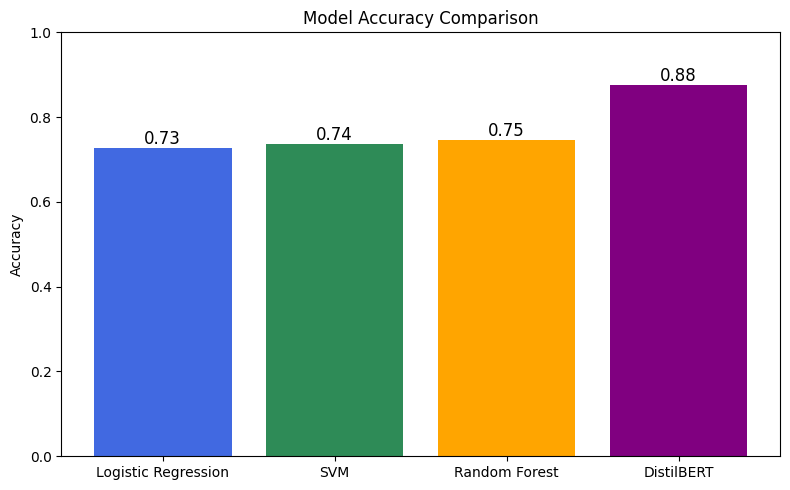

In [32]:
from sklearn.metrics import accuracy_score
import numpy as np

import matplotlib.pyplot as plt

# Prepare model predictions and names
model_preds = {
    "Logistic Regression": y_pred_log,
    "SVM": y_pred_svm,
    "Random Forest": y_pred_rf,
    "DistilBERT": pred_labels
}

# Compute accuracy for each model
accuracies = []
model_names = []
for name, preds in model_preds.items():
    # Use y_test for traditional models, test_labels for DistilBERT
    if name == "DistilBERT":
        acc = accuracy_score(test_labels, preds)
    else:
        acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    model_names.append(name)

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=['royalblue', 'seagreen', 'orange', 'purple'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.2f}", 
             ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

## Confusion Matrix

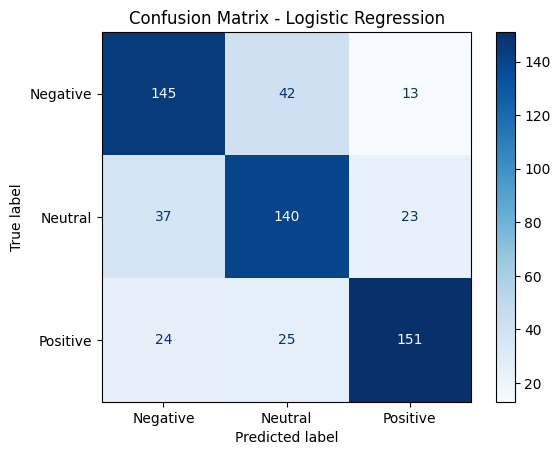

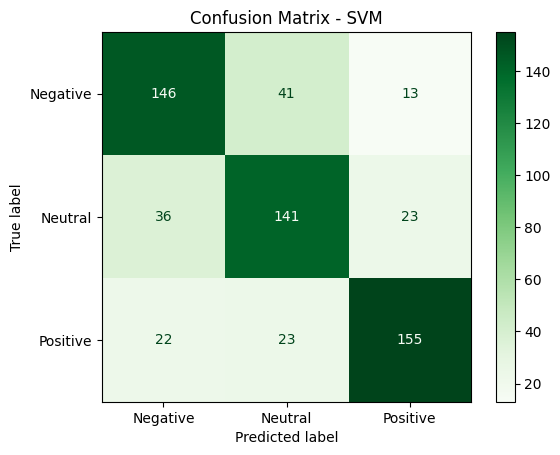

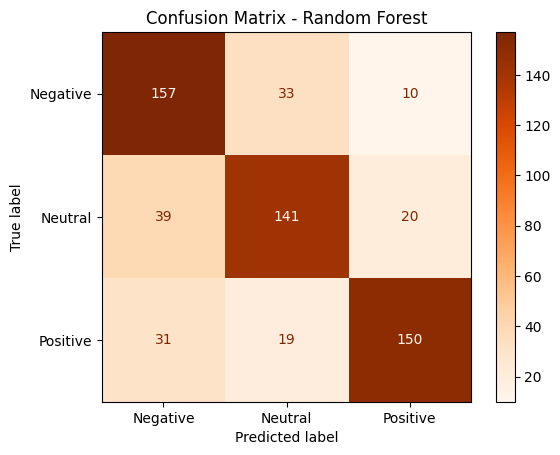

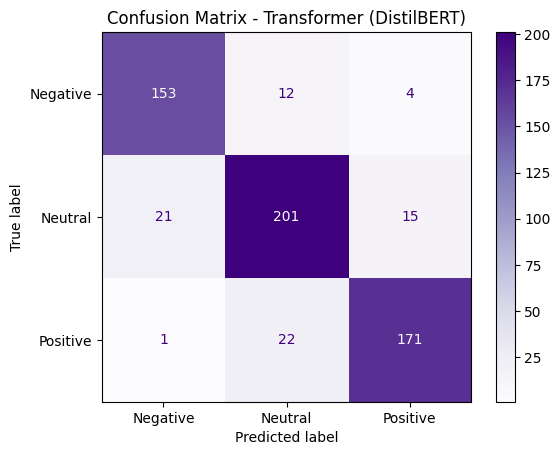

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Logistic Regression Confusion Matrix
cm_logreg = confusion_matrix(y_test, y_pred_log)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=['Negative', 'Neutral', 'Positive'])
disp_logreg.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# SVM Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Negative', 'Neutral', 'Positive'])
disp_svm.plot(cmap='Greens')
plt.title("Confusion Matrix - SVM")
plt.show()

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Negative', 'Neutral', 'Positive'])
disp_rf.plot(cmap='Oranges')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Transformer Confusion Matrix
cm_bert = confusion_matrix(test_labels, pred_labels)
disp_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=['Negative', 'Neutral', 'Positive'])
disp_bert.plot(cmap='Purples')
plt.title("Confusion Matrix - Transformer (DistilBERT)")
plt.show()


## Opinion Mining

### Extract Meaningful Opinion Pairs

In [38]:
import spacy

try:
    nlp
except NameError:
    nlp = spacy.load("en_core_web_sm")

opinion_pairs = []

for i, text in enumerate(df['selected_text'].dropna().sample(200, random_state=42)):  # sample 200 for speed
    doc = nlp(text)
    for token in doc:
        # Adjective modifying a noun
        if token.dep_ == 'amod' and token.head.pos_ == 'NOUN':
            opinion_pairs.append({
                'aspect': token.head.text,
                'opinion': token.text,
                'relation': 'amod',
                'sentence': text
            })
        # Verb opinion about a noun (e.g. "hate camera")
        elif token.pos_ == 'VERB':
            for child in token.children:
                if child.dep_ in ['dobj', 'nsubj'] and child.pos_ == 'NOUN':
                    opinion_pairs.append({
                        'aspect': child.text,
                        'opinion': token.text,
                        'relation': child.dep_,
                        'sentence': text
                    })

# Convert to DataFrame for easy viewing
import pandas as pd
opinions_df = pd.DataFrame(opinion_pairs)

# Display first few extracted pairs
from IPython.display import display
display(opinions_df.head(15))


,aspect,opinion,relation,sentence
0,hobby,fabulous,amod,well well...so sorry! let`s dance it`s fabulo...
1,tickets,has,dobj,We want to trade with someone who has Houston ...
2,hole,leave,dobj,i know! i just got off the phone with them. it...
3,hole,Giant,amod,i know! i just got off the phone with them. it...
4,Regions,closed,nsubj,i know! i just got off the phone with them. it...
5,mothers,Happy,amod,Happy mothers day everybody
6,pals,have,dobj,"hey, but you have gal pals here in Phoenix!!!"
7,pals,gal,amod,"hey, but you have gal pals here in Phoenix!!!"
8,star,replies,nsubj,No star replies to me
9,Birthday,bowling,nsubj,GRANADA BOWL WITH THE CREW! Birthday bowling f...


### Top 10 Opinion Words

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

!pip install wordcloud
from wordcloud import WordCloud


C:\Users\user\AppData\Local\Temp\ipykernel_1968\2302606294.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_opinions.values, y=top_opinions.index, palette="rocket")


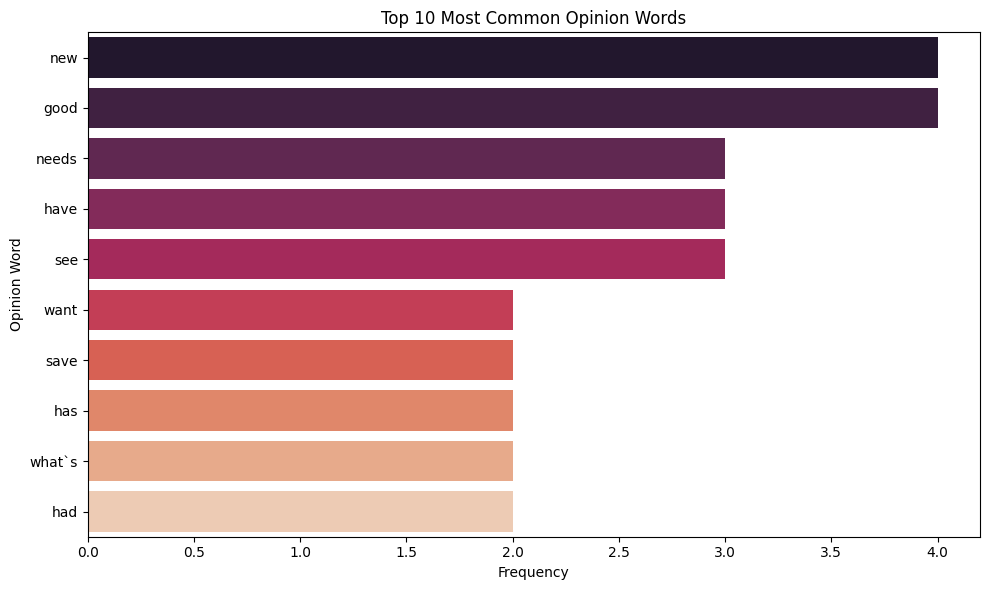

In [40]:
# Count top opinion words
top_opinions = opinions_df['opinion'].value_counts().nlargest(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_opinions.values, y=top_opinions.index, palette="rocket")
plt.title("Top 10 Most Common Opinion Words")
plt.xlabel("Frequency")
plt.ylabel("Opinion Word")
plt.tight_layout()
plt.show()


### Opinion WordCloud

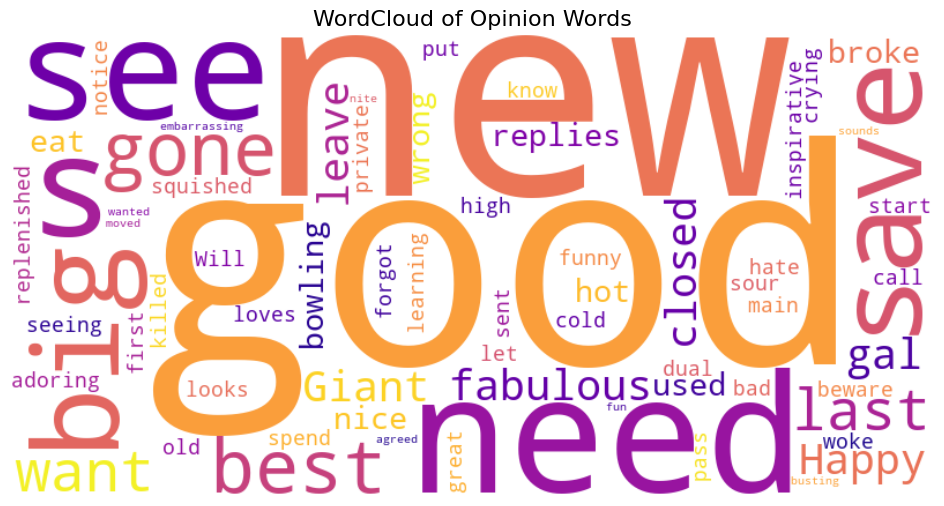

In [41]:
# Join all opinion words into one string
opinion_text = " ".join(opinions_df['opinion'].dropna().astype(str).tolist())

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(opinion_text)

# Display it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Opinion Words", fontsize=16)
plt.show()


In [42]:
joblib.dump(df, "text_dataset.pkl")

['text_dataset.pkl']

# ABSA using spaCy + VADER

In [43]:
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Load models
nlp = spacy.load("en_core_web_sm")
sia = SentimentIntensityAnalyzer()

# Store results
absa_results = []

# Sample 200 sentences (for performance)
sample_texts = df['selected_text'].dropna().sample(200, random_state=42).tolist()

for sentence in sample_texts:
    doc = nlp(sentence)

    # Get overall sentiment of the sentence
    sentiment_score = sia.polarity_scores(sentence)['compound']
    if sentiment_score >= 0.05:
        sent_label = 'positive'
    elif sentiment_score <= -0.05:
        sent_label = 'negative'
    else:
        sent_label = 'neutral'

    # Extract aspects via opinion-based dependency parsing
    for token in doc:
        # Adjective modifying a noun
        if token.dep_ == 'amod' and token.head.pos_ == 'NOUN':
            absa_results.append({
                'sentence': sentence,
                'aspect': token.head.text.lower(),
                'opinion_word': token.text.lower(),
                'relation': 'amod',
                'sentiment': sent_label
            })

        # Verb opinion towards a noun
        elif token.pos_ == 'VERB':
            for child in token.children:
                if child.dep_ in ['dobj', 'nsubj'] and child.pos_ == 'NOUN':
                    absa_results.append({
                        'sentence': sentence,
                        'aspect': child.text.lower(),
                        'opinion_word': token.text.lower(),
                        'relation': child.dep_,
                        'sentiment': sent_label
                    })

# Convert to DataFrame
absa_df = pd.DataFrame(absa_results)

# Show preview
absa_df.head(15)



,sentence,aspect,opinion_word,relation,sentiment
0,well well...so sorry! let`s dance it`s fabulo...,hobby,fabulous,amod,positive
1,We want to trade with someone who has Houston ...,tickets,has,dobj,negative
2,i know! i just got off the phone with them. it...,hole,leave,dobj,negative
3,i know! i just got off the phone with them. it...,hole,giant,amod,negative
4,i know! i just got off the phone with them. it...,regions,closed,nsubj,negative
5,Happy mothers day everybody,mothers,happy,amod,positive
6,"hey, but you have gal pals here in Phoenix!!!",pals,have,dobj,neutral
7,"hey, but you have gal pals here in Phoenix!!!",pals,gal,amod,neutral
8,No star replies to me,star,replies,nsubj,negative
9,GRANADA BOWL WITH THE CREW! Birthday bowling f...,birthday,bowling,nsubj,neutral
